<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/QuantumSubroutineAlgorithms_QAA_ChatGPT_mkbahk_20250407.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.7 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=7741739c62fcedd1ac07524b4391e35a9d1ef5b2e4fa457d4807cbdea1537d1e
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 53.6 MB/s eta 0:00:00
  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-s4pezpij
  Running comman

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
from qiskit_aer import Aer, AerSimulator
from IPython.display import display, Math
import numpy as np

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZGate


#결과가 않나옴

In [4]:
# 1. 초기 상태 준비: 2 큐비트를 모두 Hadamard 게이트로 균등 초위상 상태로 설정
n_qubits = 2
qc = QuantumCircuit(n_qubits)

# 모든 큐비트를 균등한 상태로 만듬: (|00⟩ + |01⟩ + |10⟩ + |11⟩)/2
qc.h(range(n_qubits))

# 2. 오라클 정의: 여기서는 우리가 찾고자 하는 "좋은 상태"를 |11⟩로 설정
# |11⟩ 상태에 대해 -1 위상을 주는 회로
oracle = QuantumCircuit(n_qubits)
oracle.cz(0, 1)  # 두 큐비트가 모두 1일 때만 위상 반전
oracle_gate = oracle.to_gate()
oracle_gate.name = "Oracle"

# 3. Grover Diffusion Operator 정의
# - 모든 상태의 평균에 대한 반사 수행 (평균 진폭을 기준으로 good state 증폭)
diffusion = QuantumCircuit(n_qubits)

# 상태를 Hadamard로 변환 -> X로 반사 -> 다중 제어-Z -> 다시 Hadamard
diffusion.h(range(n_qubits))
diffusion.x(range(n_qubits))
diffusion.h(n_qubits - 1)       # 제어 Z를 구현하기 위한 H 게이트
diffusion.cz(0, 1)              # 다중 제어 Z (2큐비트에서는 간단한 CZ)
diffusion.h(n_qubits - 1)       # 다시 H
diffusion.x(range(n_qubits))
diffusion.h(range(n_qubits))

diffusion_gate = diffusion.to_gate()
diffusion_gate.name = "Diffusion"

# 4. QAA 연산자 적용: Oracle → Diffusion 순으로 1회 반복 (n=1)
qc.append(oracle_gate, range(n_qubits))
qc.append(diffusion_gate, range(n_qubits))

# 5. 측정 추가
qc.measure_all()

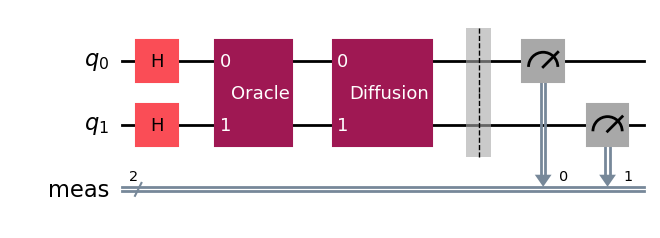

In [12]:
qc.draw('mpl')

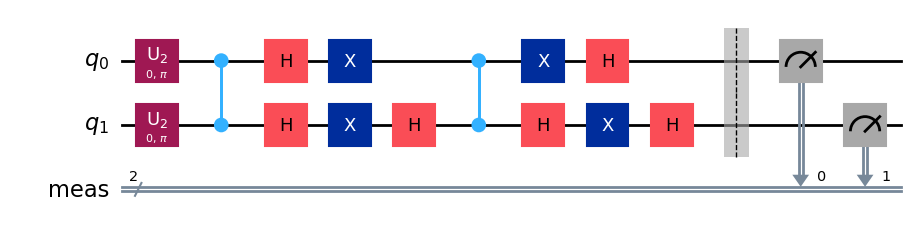

In [13]:
qc.decompose().draw('mpl')

In [14]:
# 6. 시뮬레이션 실행
backend = Aer.get_backend('qasm_simulator')
# Transpile the circuit for the qasm_simulator backend
transpiled_qc = transpile(qc, backend)


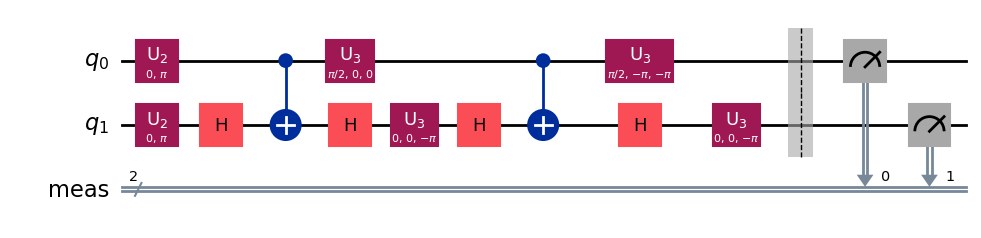

In [15]:
transpiled_qc.decompose().draw('mpl')

In [16]:

result = backend.run(transpiled_qc, shots=1000).result()
counts = result.get_counts()

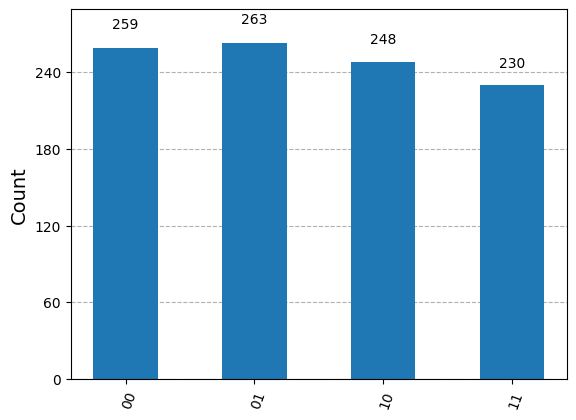

In [17]:
# 결과 시각화
plot_histogram(counts)